In [1]:
pip install nibabel numpy scipy matplotlib scikit-image torch torchvision pandas


Note: you may need to restart the kernel to use updated packages.


📊 Precisión (Accuracy): 0.7895
📊 Precisión Balanceada: 0.7949
📊 Sensibilidad (Recall): 0.7949
📊 F1-Score: 0.8003

📊 Matriz de Confusión:
[[41  3  4]
 [ 3 72 11]
 [ 1 22 52]]

📊 Precisión por clase:
Clase AD: 0.9111
Clase CN: 0.7423
Clase MCI: 0.7761


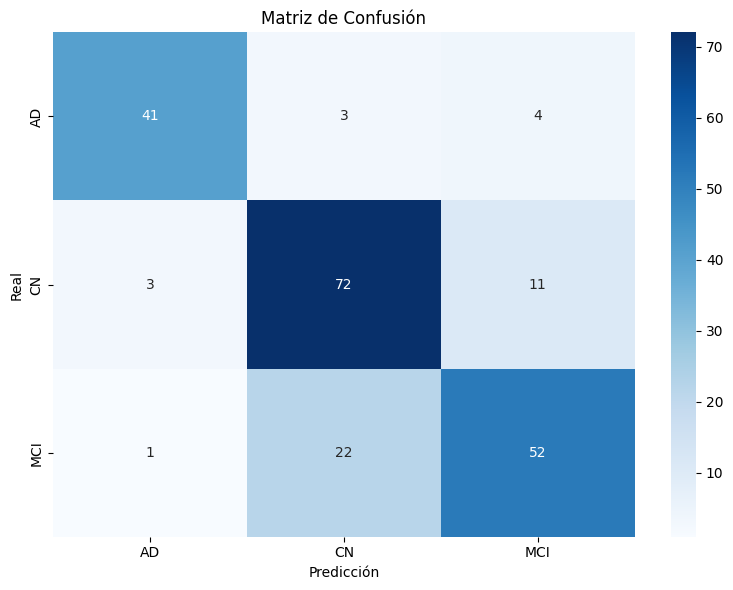

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_score
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CONFIGURACIÓN ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
TARGET_SHAPE = (128, 128, 128)
MODEL_PATH = "alzenet3d_nifti.pth"
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"

# ========== DATASET NIFTI ==========
class NiftiDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        img = nib.load(path)
        volume = img.get_fdata().astype(np.float32)

        # Normalización z-score
        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)

        # Resize
        volume = self.resize_volume(volume, TARGET_SHAPE)

        volume = np.expand_dims(volume, axis=0)  # [1, D, H, W]
        return torch.tensor(volume), torch.tensor(self.label_encoder.transform([label])[0])

    def resize_volume(self, volume, target_shape):
        volume = torch.tensor(volume).unsqueeze(0).unsqueeze(0)  # [1,1,D,H,W]
        volume_resized = F.interpolate(volume, size=target_shape, mode="trilinear", align_corners=False)
        return volume_resized.squeeze().numpy()

# ========== MODELO ALZENET ==========
class AlzeNet3D(nn.Module):
    def __init__(self, num_classes=3):
        super(AlzeNet3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool3d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16 * 16, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ========== CARGAR DATOS ==========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)

val_dataset = NiftiDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== CARGAR MODELO ==========
model = AlzeNet3D(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== INFERENCIA Y MÉTRICAS ==========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ====== CALCULAR MÉTRICAS ======
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)
precision_per_class = precision_score(y_true, y_pred, average=None)

# ====== MOSTRAR RESULTADOS ======
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

# Precisión por clase
print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ====== MATRIZ DE CONFUSIÓN GRAFICADA ======
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.7512
📊 Precisión Balanceada: 0.7611
📊 Sensibilidad (Recall): 0.7611
📊 F1-Score: 0.7565

📊 Matriz de Confusión:
[[41  5  2]
 [ 5 69 12]
 [ 6 22 47]]

📊 Precisión por clase:
Clase AD: 0.7885
Clase CN: 0.7188
Clase MCI: 0.7705


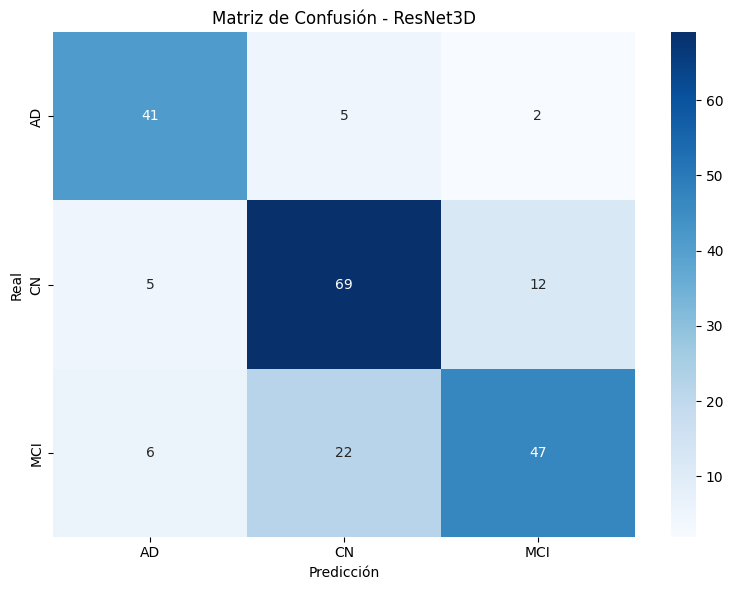

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

# ========== CONFIGURACIÓN ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 2
MODEL_PATH = "resnet3d_alzheimer_extended.pth"

# ========== DATASET ==========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)

        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])

        return volume, label

# ========== MODELO RESNET3D ==========
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def resnet18_3d(num_classes):
    return ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes)

# ========== CARGA DE DATOS ==========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)
val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== CARGAR MODELO ==========
model = resnet18_3d(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== INFERENCIA Y MÉTRICAS ==========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ========== CALCULAR MÉTRICAS ==========
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========== MOSTRAR RESULTADOS ==========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

# Precisión por clase
print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========== MATRIZ DE CONFUSIÓN GRAFICADA ==========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - ResNet3D")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.5455
📊 Precisión Balanceada: 0.5245
📊 Sensibilidad (Recall): 0.5245
📊 F1-Score: 0.5305

📊 Matriz de Confusión:
[[16  1 31]
 [ 3 39 44]
 [ 0 16 59]]

📊 Precisión por clase:
Clase AD: 0.8421
Clase CN: 0.6964
Clase MCI: 0.4403


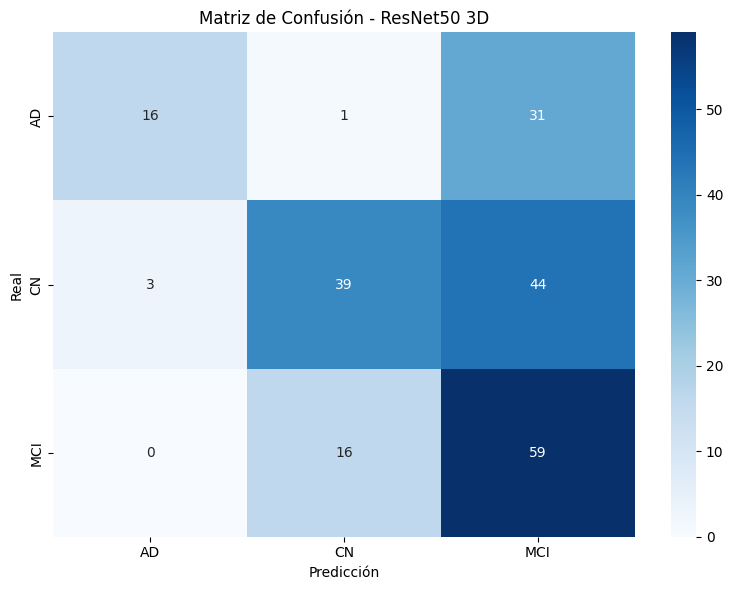

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import torch.nn.functional as F
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CONFIGURACIÓN ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 1
MODEL_PATH = "resnet50_3d_alzheimer.pth"

# ========== DATASET ==========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)
        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])

        return volume, label

# ========== RESNET50 3D ==========
class Bottleneck3D(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        return self.relu(out)

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def resnet50_3d(num_classes):
    return ResNet3D(Bottleneck3D, [3, 4, 6, 3], num_classes)

# ========== CARGAR DATOS ==========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)
val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== CARGAR MODELO ==========
model = resnet50_3d(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== INFERENCIA Y MÉTRICAS ==========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ========== CÁLCULO DE MÉTRICAS ==========
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========== MOSTRAR RESULTADOS ==========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

# Precisión por clase
print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========== MATRIZ DE CONFUSIÓN GRAFICADA ==========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - ResNet50 3D")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.7895
📊 Precisión Balanceada: 0.7821
📊 Sensibilidad (Recall): 0.7821
📊 F1-Score: 0.7916

📊 Matriz de Confusión:
[[37  4  7]
 [ 2 77  7]
 [ 2 22 51]]

📊 Precisión por clase:
Clase AD: 0.9024
Clase CN: 0.7476
Clase MCI: 0.7846


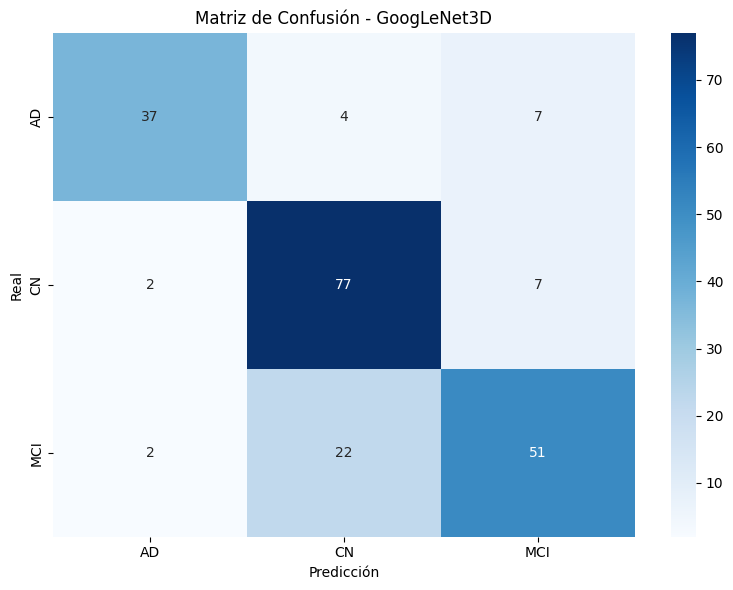

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import torch.nn.functional as F
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CONFIGURACIÓN ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 2
MODEL_PATH = "googlenet3d_alzheimer_extended4.pth"

# ========== DATASET ==========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)
        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])

        return volume, label

# ========== MODELO GOOGLE NET 3D ==========
class GoogLeNet3D(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(3, stride=2, padding=1),
            nn.Conv3d(64, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(3, stride=2, padding=1),
            nn.Conv3d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ========== CARGAR DATOS ==========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)
val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== CARGAR MODELO ==========
model = GoogLeNet3D(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========== INFERENCIA Y MÉTRICAS ==========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ========== CÁLCULO DE MÉTRICAS ==========
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========== MOSTRAR RESULTADOS ==========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

# Precisión por clase
print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========== MATRIZ DE CONFUSIÓN GRAFICADA ==========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - GoogLeNet3D")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.7703
📊 Precisión Balanceada: 0.7930
📊 Sensibilidad (Recall): 0.7930
📊 F1-Score: 0.7721

📊 Matriz de Confusión:
[[46  0  2]
 [ 4 66 16]
 [14 12 49]]

📊 Precisión por clase:
Clase AD: 0.7188
Clase CN: 0.8462
Clase MCI: 0.7313


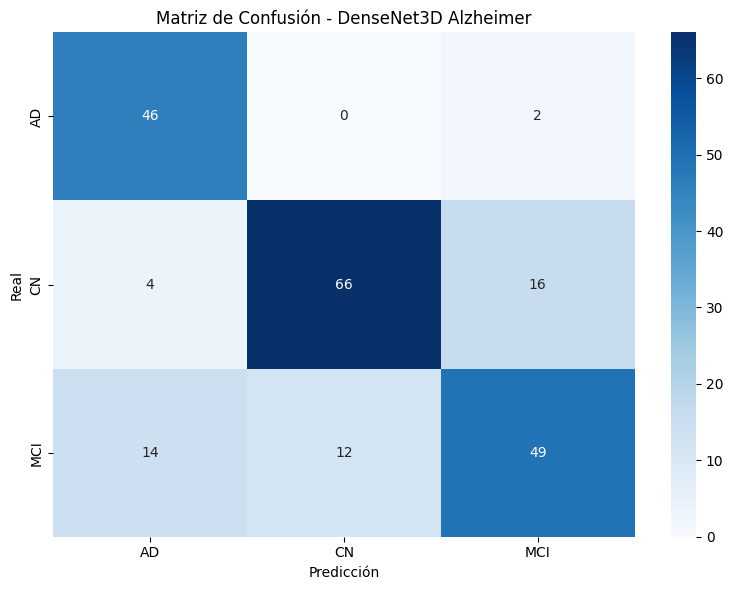

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========= CONFIGURACIÓN =========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 2
MODEL_PATH = "densenet3d_alzheimer-extended7.pth"

# ========= DATASET =========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)
        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])

        return volume, label

# ========= MODELO DENSENET3D =========
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.norm = nn.BatchNorm3d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv3d(in_channels, growth_rate, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv(self.relu(self.norm(x)))
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.norm = nn.BatchNorm3d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        return self.pool(x)

class DenseNet3D(nn.Module):
    def __init__(self, in_channels, growth_rate, block_config, num_classes):
        super(DenseNet3D, self).__init__()
        num_init_features = 2 * growth_rate

        self.features = nn.Sequential(
            nn.Conv3d(in_channels, num_init_features, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm3d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_features, num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2

        self.features.add_module('norm_final', nn.BatchNorm3d(num_features))
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# ========= CARGAR DATOS =========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)
val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========= CARGAR MODELO =========
model = DenseNet3D(
    in_channels=1,
    growth_rate=16,
    block_config=(4, 4, 4),
    num_classes=len(le.classes_)
).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========= INFERENCIA Y MÉTRICAS =========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ========= CALCULAR MÉTRICAS =========
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========= MOSTRAR RESULTADOS =========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========= MATRIZ DE CONFUSIÓN GRAFICADA =========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - DenseNet3D Alzheimer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.6220
📊 Precisión Balanceada: 0.6320
📊 Sensibilidad (Recall): 0.6320
📊 F1-Score: 0.6305

📊 Matriz de Confusión:
[[31  2 15]
 [ 5 41 40]
 [ 6 11 58]]

📊 Precisión por clase:
Clase AD: 0.7381
Clase CN: 0.7593
Clase MCI: 0.5133


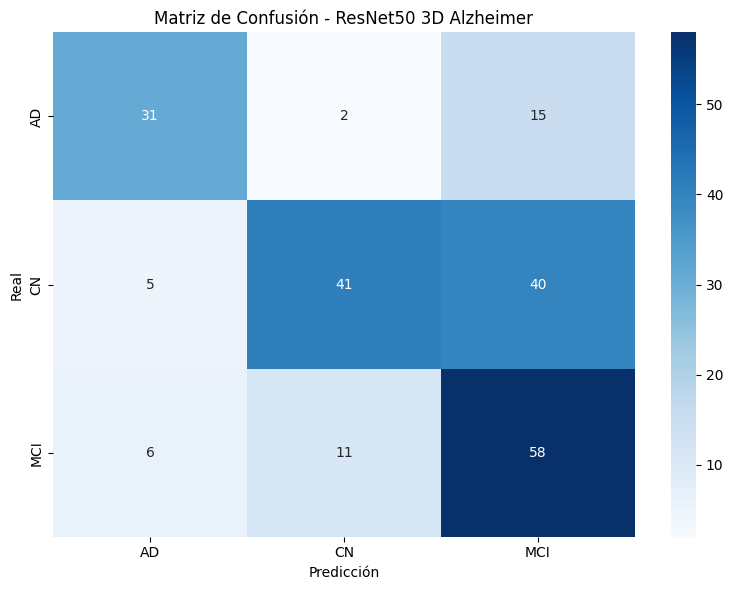

: 

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========= CONFIGURACIÓN =========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 1
MODEL_PATH = "resnet50_3d_alzheimer.pth"

# ========= DATASET =========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)
        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])

        return volume, label

# ========= MODELO RESNET50 3D =========
class Bottleneck3D(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out += identity
        return self.relu(out)

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

def resnet50_3d(num_classes):
    return ResNet3D(Bottleneck3D, [3, 4, 6, 3], num_classes)

# ========= CARGAR DATOS =========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)
val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========= CARGAR MODELO =========
model = resnet50_3d(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========= INFERENCIA Y MÉTRICAS =========
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE).float(), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ========= CALCULAR MÉTRICAS =========
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========= MOSTRAR RESULTADOS =========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print("\n📊 Matriz de Confusión:")
print(cm)

print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========= MATRIZ DE CONFUSIÓN GRAFICADA =========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - ResNet50 3D Alzheimer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.7177
📊 Precisión Balanceada: 0.7099
📊 Sensibilidad (Recall): 0.7099
📊 F1-Score: 0.7252

📊 Matriz de Confusión:
[[33  3 12]
 [ 1 69 16]
 [ 2 25 48]]

📊 Precisión por clase:
Clase AD: 0.9167
Clase CN: 0.7113
Clase MCI: 0.6316


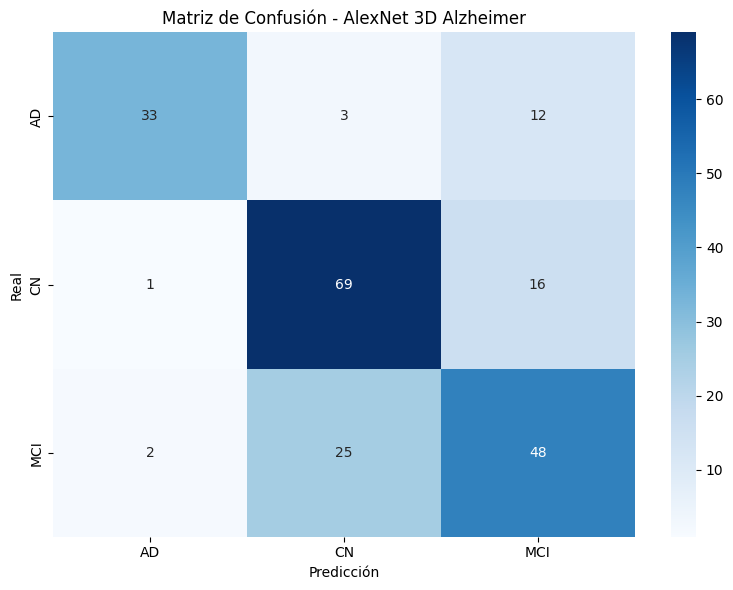

: 

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========= CONFIGURACIÓN =========
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
MODEL_PATH = "alexnet3d_alzheimer_extended2.pth"  # <-- Modelo que quieres evaluar
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= DATASET =========
class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]
        volume = nib.load(path).get_fdata().astype(np.float32)

        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)

        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)
        volume = torch.tensor(volume).unsqueeze(0)
        label = torch.tensor(self.label_encoder.transform([label])[0])
        return volume, label

# ========= MODELO =========
class AlexNet3D(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# ========= CARGA DE DATOS =========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)

val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ========= CARGAR MODELO =========
model = AlexNet3D(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========= INFERENCIA =========
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========= MÉTRICAS =========
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========= MOSTRAR RESULTADOS =========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")

print("\n📊 Matriz de Confusión:")
print(cm)

print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========= MATRIZ DE CONFUSIÓN GRAFICADA =========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - AlexNet 3D Alzheimer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


📊 Precisión (Accuracy): 0.8325
📊 Precisión Balanceada: 0.8368
📊 Sensibilidad (Recall): 0.8368
📊 F1-Score: 0.8464

📊 Matriz de Confusión:
[[42  1  5]
 [ 0 73 13]
 [ 0 16 59]]

📊 Precisión por clase:
Clase AD: 1.0000
Clase CN: 0.8111
Clase MCI: 0.7662


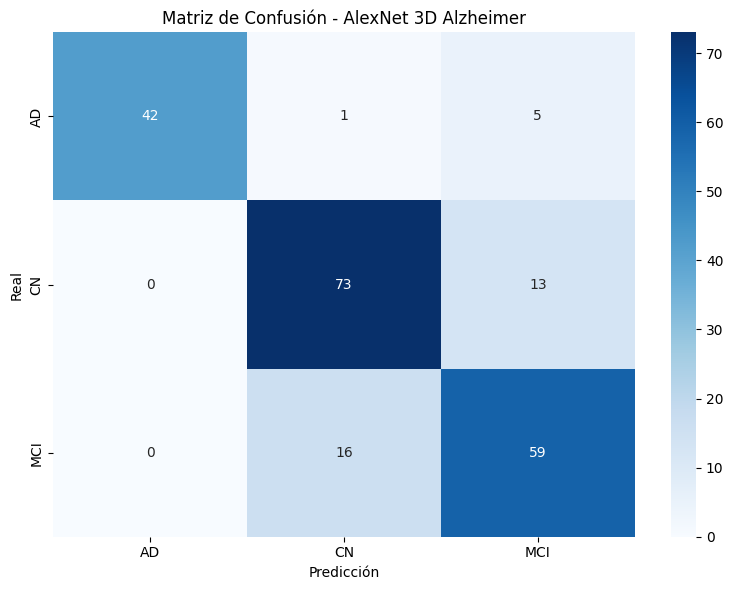

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.ndimage
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ========= CONFIGURACIÓN =========
CSV_PATH = r"D:/ADNI Data/BETandGroups.csv"
MODEL_PATH = r"D:\ADNI Data\Repo python\14MBID_TFM_NicolasAlzate\vgg16_3d_alzheimer6_cont.pth"  # <-- Modelo que quieres evaluar
IMG_SIZE = (128, 128, 128)
BATCH_SIZE = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Nifti3DDataset(Dataset):
    def __init__(self, df, label_encoder):
        self.df = df.reset_index(drop=True)
        self.label_encoder = label_encoder
        self.target_shape = IMG_SIZE

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "Ruta"]
        label = self.df.loc[idx, "Grupo"]

        volume = nib.load(path).get_fdata().astype(np.float32)
        zoom_factors = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = scipy.ndimage.zoom(volume, zoom=zoom_factors, order=3)
        volume = (volume - np.mean(volume)) / (np.std(volume) + 1e-8)
        volume = np.clip(volume, -3, 3)

        volume = torch.tensor(volume).unsqueeze(0)  # [1, D, H, W]
        label = torch.tensor(self.label_encoder.transform([label])[0])
        return volume, label

# ========= MODELO =========
class VGG3D(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(64, 64, 3, padding=1), nn.ReLU(True),
            nn.MaxPool3d(2, 2),

            nn.Conv3d(64, 128, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(128, 128, 3, padding=1), nn.ReLU(True),
            nn.MaxPool3d(2, 2),

            nn.Conv3d(128, 256, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(256, 256, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(256, 256, 3, padding=1), nn.ReLU(True),
            nn.MaxPool3d(2, 2),

            nn.Conv3d(256, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.MaxPool3d(2, 2),

            nn.Conv3d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.Conv3d(512, 512, 3, padding=1), nn.ReLU(True),
            nn.MaxPool3d(2, 2)
        )
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ========= CARGA DE DATOS =========
df = pd.read_csv(CSV_PATH)
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Grupo'])

_, df_val = train_test_split(df, test_size=0.25, stratify=df['labels'], random_state=42)

val_dataset = Nifti3DDataset(df_val, le)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ========= CARGAR MODELO =========
model = VGG3D(num_classes=len(le.classes_)).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ========= INFERENCIA =========
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========= MÉTRICAS =========
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision_per_class = precision_score(y_true, y_pred, average=None)
cm = confusion_matrix(y_true, y_pred)

# ========= MOSTRAR RESULTADOS =========
print(f"📊 Precisión (Accuracy): {accuracy:.4f}")
print(f"📊 Precisión Balanceada: {balanced_acc:.4f}")
print(f"📊 Sensibilidad (Recall): {recall:.4f}")
print(f"📊 F1-Score: {f1:.4f}")

print("\n📊 Matriz de Confusión:")
print(cm)

print("\n📊 Precisión por clase:")
for idx, class_name in enumerate(le.classes_):
    print(f"Clase {class_name}: {precision_per_class[idx]:.4f}")

# ========= MATRIZ DE CONFUSIÓN GRAFICADA =========
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - VGG16 3D Alzheimer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


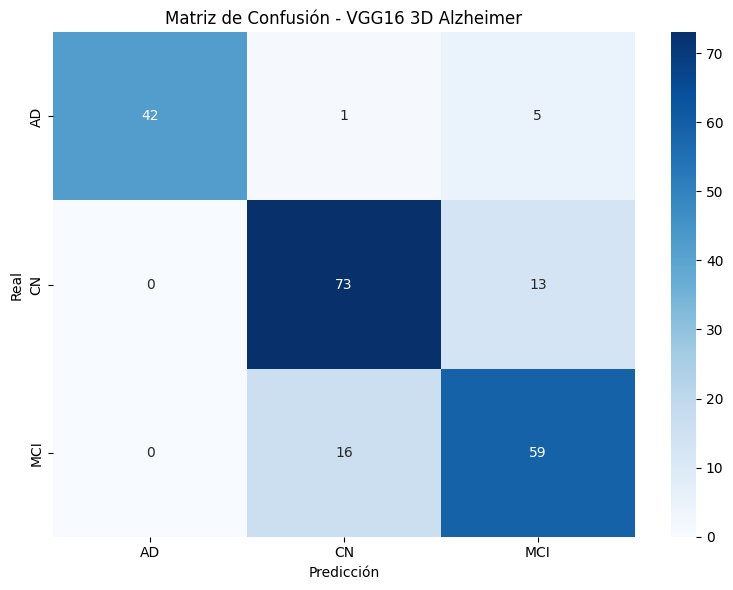

In [3]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - VGG16 3D Alzheimer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()